In [1]:
import sys
import os
#sys.path.append('D:\\software_git_repos\\cofe-python-analysis-tools\\utils_meinhold')
sys.path.append('../utils_meinhold')
#sys.path.append('D:\\software_git_repos\\cofe-python-analysis-tools\\utils_zonca')
sys.path.append('../utils_zonca')
#sys.path.append('D:\\software_git_repos\\cofe-python-analysis-tools\\utils_zonca\\pointing')
sys.path.append('../utils_zonca/pointing')
#sys.path.append('D:\\software_git_repos\\greenpol')
sys.path.append('../')
#sys.path.append('D:\\software_git_repos\\greenpol\\telescope_control\\')
sys.path.append('../telescope_control')
#sys.path.append('D:\\software_git_repos\\greenpol\\telescope_control\\VtoT\\')
sys.path.append('../VtoT')
import realtime_gp as rt
import numpy as np
import datetime 
import h5py
#import pandas as pd
#from pointingtools import compute_parallactic_angle, altaz2ha 
#from planets import getlocation, getpointing
import warnings
#from astropy.coordinates import AltAz, Angle, EarthLocation, ICRS, SkyCoord, frame_transform_graph
#from astropy import units as u
#import ephem
import matplotlib.pyplot as plt
import time
#import planets
import convert
from datetime import timedelta
#import numpy.ma as ma
import cofe_util as cu

import Tkinter,tkFileDialog

from Tkinter import *
import ttk

import pickle
import glob

import cPickle

from scipy.optimize import curve_fit

%pylab

J:\polaris\polaris_software\notebook
Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


c:\users\labuser\anaconda3\envs\py27\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Widget', 'Text', 'Button']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def get_pointing_files(filelist=None):

    if filelist==None:
        root=Tkinter.Tk()
        filelist = list(tkFileDialog.askopenfilenames(\
        initialdir='D://software_git_repos/greenpol/telescope_control/data_aquisition/pointing_data/',parent=root,title='Choose a set of files'))
        root.destroy()
    filelist.sort()
    
    return filelist

In [3]:
def read_some_data(datadict,datalabel,datatype='demod', filelist=None):

    if filelist==None:
        root=Tkinter.Tk()
        if datatype=='demod':
            filelist = list(tkFileDialog.askopenfilenames(\
            initialdir='D://software_git_repos/greenpol/telescope_control/data_aquisition/demod_data/',parent=root,title='Choose a set of files'))
        if datatype=='raw':
            filelist = list(tkFileDialog.askopenfilenames(\
            initialdir='D://software_git_repos/greenpol/telescope_control/data_aquisition/data/',parent=root,title='Choose a set of files'))            
        root.destroy()
    filelist.sort()
    
    if datatype=='demod':
        dlist=[]
        for f in filelist:
            hf=h5py.File(f)
            dlist.append(hf['demod_data'])
        d=concatenate(dlist)
        hf.close() 
        
    if datatype=='raw':
        d=rt.demod.read_raw(filelist)
    datadict[datalabel]=d
    return

In [4]:
def get_file_times(fld):
    startfile = fld[0][:65]+fld[0][71:-2]+'dat'
    endfile = fld[-1][:65]+fld[-1][71:-2]+'dat'
    
    #starttime = os.path.getctime(startfile)
    starttime= os.stat(startfile).st_mtime
    starttime = datetime.datetime.fromtimestamp(starttime)

    #endtime = os.path.getctime(endfile)
    endtime= os.stat(endfile).st_mtime
    endtime = datetime.datetime.fromtimestamp(endtime)
    
    return starttime, endtime

In [5]:
def plot_toi_dict(toi_dict,chanlist=['H1HiAC'],componentlist=['T'],datalist=None, kperv=[1]):
    #function to give a choice of preloaded datasets from dictionary data_dict
    figure()
    if datalist==None:
        datalist=toi_dict.keys()
    if len(componentlist)==1:  # if componentlist is a single value, assume same thing for all chans
        c=componentlist[0]
        componentlist=[c for n in chanlist]
    #set up the color sequence for the plot
    nlines=len(datalist)*len(chanlist)
    colormap = cm.gist_ncar
    gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, nlines)])
    titletxt=[]
    count = 0
    for dname in datalist:
        samprate=1000./(toi_dict[dname]['rev'][1]-toi_dict[dname]['rev'][0])
        titletxt.append(dname)
        for channame,component in zip(chanlist,componentlist):
            try:
                toi=toi_dict[dname][rt.nametochan(channame)][component] #if it's demod data so a dict
                print dname + channame + ' mean value: ', toi.mean()
                t=toi_dict[dname]['azi'][0]+arange(len(toi))/samprate
                if len(kperv)==1 and kperv[0]==1.0:
                    plot(t,toi*kperv[count],label=dname+ '  '+channame+' '+component,lw=2)
                else:
                    plot(t,toi*kperv[count],label=dname+ '  '+channame+' '+component+' gain= '+str(kperv[count]),lw=2)
                if (count+1) < len(kperv):
                    count += 1
            except:
                toi=toi_dict[dname][rt.nametochan(channame)].flatten()#if it's raw data so not a dict
                print dname + ' ' + channame + ' mean value: ', toi.mean()
                t=toi_dict[dname]['azi'][0]+arange(len(toi))/(256.*samprate)
                if len(kperv)==1 and kperv[0]==1.0:
                    plot(t,toi*kperv[count],label=dname+ '  '+channame+' '+component,lw=2)
                else:
                    plot(t,toi*kperv[count],label=dname+ '  '+channame+' '+component+' gain= '+str(kperv[count]),lw=2) 
                if (count+1) < len(kperv):
                    count += 1
                
    title(titletxt)
    legend()
    xlabel('Time [S]')
    if len(kperv) == 1 and kperv[0] == 1:
        ylabel('Output [v]')
    else:
        ylabel('Output [T]')

In [30]:
def asd_from_dict(data_dict,minfreq=1.):
    #run nps on all the channels for each of the loaded data sets, return asd dictionary
    asd_dict={}
    chans=['ch%s' %str(i) for i in range(16)]
    for datset in data_dict.keys():
        asd_dict[datset]={}
        datatype='demod'
        print(datset)
        d=data_dict[datset]
        if len(d.dtype)==18:
            datatype='raw'
        print d['rev'][10], d['rev'][9]
        samprate=1000./float(d['rev'][10]-d['rev'][9])
        for chan in chans:
            if datatype=='raw':
                freq,psd=cu.nps(d[chan].flatten(),samprate*256,minfreq=minfreq)
                asd_dict[datset]['freq']=freq
                asd_dict[datset][chan]=sqrt(psd)
            if datatype=='demod':
                asd_dict[datset][chan]={}
                for component in ['T','Q','U']:
                    freq,psd=cu.nps(d[chan][component],samprate,minfreq=minfreq)
                    asd_dict[datset][chan][component]=sqrt(psd)
                    asd_dict[datset]['freq']=freq
                    
    return asd_dict            

In [7]:
def plot_asd_dict(asd_dict,chanlist=['H1HiAC'],componentlist=['T'],datalist=None,kperv=[1]):
    #function to give a choice of preloaded datasets from dictionary data_dict
    figure()
    if datalist==None:
        datalist=asd_dict.keys()
    if len(componentlist)==1:  # if componentlist is a single value, assume same thing for all chans
        c=componentlist[0]
        componentlist=[c for n in datalist]
    #set up the color sequence for the plot
    nlines=len(datalist)*len(chanlist)
    colormap = cm.gist_ncar
    gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, nlines)])
    
    count = 0
    for dname in datalist:
        for channame,component in zip(chanlist,componentlist):
            try:
                asd=asd_dict[dname][rt.nametochan(channame)][component] #if it's demod data so a dict
            except:
                asd=asd_dict[dname][rt.nametochan(channame)]           #if it's raw data so not a dict
            if len(kperv) == 1 and kperv[0] == 1.0:
                plot(asd_dict[dname]['freq'],asd*kperv[count],label=dname+ '  '+channame+' '+component,lw=2)
            else:
                plot(asd_dict[dname]['freq'],asd*kperv[count],label=dname+ '  '+channame+' '+component+' gain= '+str(kperv[count]),lw=2)
            if (count+1) < len(kperv):
                count += 1
    legend()
    xlabel('Frequency [Hz]')
    if len(kperv) == 1 and kperv[0] == 1:
        ylabel(r'ASD [$\frac{V}{\sqrt{Hz}}$]')
    else:
        ylabel(r'ASD [$\frac{T}{\sqrt{Hz}}$]')

In [8]:
ddict={}

In [26]:
read_some_data(ddict,'azoff',datatype='raw')

1001
16


1000
16


1000
16


1000
16


1000
16


In [27]:
ddict.keys()

['azoff', 'azon']

In [31]:
asd_dict = asd_from_dict(ddict, minfreq=0.1)

azoff
0 0


ZeroDivisionError: float division by zero

In [49]:
pp = {}

In [50]:
flp = get_pointing_files()
pp['skydip'] = rt.get_h5_pointing(flp)

In [51]:
combined = rt.combine_cofe_h5_pointing(ddict['skydip'], pp['skydip'])

In [14]:
chan = 'H1HiDC'
var = 'T'

In [ ]:
el = combined['el']
data = -combined['sci_data'][rt.nametochan(chan)][var]

In [126]:
figure()
plot(el, data)

In [109]:
#igood = np.where(el > 22.0)[0]
igood = np.where(np.arange(len(data)) < 2000)[0]
#igood = np.where(np.arange(len(data)) > 4822)[0]
el = el[igood]
data = data[igood]

In [34]:
figure()
plot(el, data)

In [113]:
def func(el, Vsys, Vz):
    return Vsys + Vz/np.sin(el)

In [114]:
popt, pcov = curve_fit(func, np.radians(el), data)

In [115]:
figure()
plot(el, data, 'b-', linewidth=2, label='%s %s' % (chan, var))
plot(el, func(np.radians(el), *popt), 'r-', label='fit: Vsys=%.3f V, Vz=%.3f V' % tuple(popt))
ylabel('Signal (Volts)')
xlabel('Elevation (deg)')
legend()

In [116]:
#now get par cal and clear sky voltages and plug into notebook equation to get gain
beta = {'H1': 0.12419560576729863, 'H2':0.12628101445342926, 'H3': 0.11703026443075649}

In [48]:
plot_toi_dict(ddict,chanlist=['H1HiDC'],componentlist=['T'],datalist=['amb'])

amb H1HiDC mean value:  -0.0433360855422


C:\Users\labuser\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:20: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


c:\users\labuser\anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  if sys.path[0] == '':


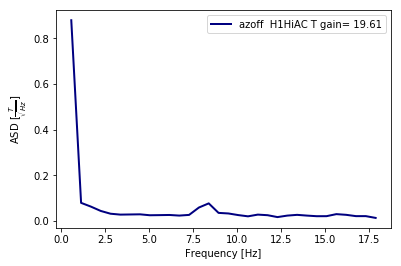

In [19]:
plot_asd_dict(asd_dict,chanlist=['H1HiAC'],componentlist=['T'],datalist=['azoff'],kperv=[19.61])

In [118]:
np.nanmean(pp['skydip']['Calibrator'])

272.45038545318022

In [130]:
asd = [0.0034,0.0027, 0.0074]

for chan in ['H1HiDC','H2HiDC', 'H3HiDC']:
    
    Tamb = 287.09 #np.nanmean(pp['skydip']['Calibrator'])
    Vsys = popt[0]
    Vz = popt[1]
    elevation = pp['sky']['el'].mean()

    try:
        Vpar = ddict['par'][rt.nametochan(chan)][var].mean()
        Vsky = ddict['sky'][rt.nametochan(chan)][var].mean()
    except:
        Vpar = ddict['par'][rt.nametochan(chan)].flatten().mean()
        Vsky = ddict['sky'][rt.nametochan(chan)].flatten().mean()

    h = int(chan[1])   

    Vpar_lin = rt.linearize_Vexp(Vpar, h)
    Vsky_lin = rt.linearize_Vexp(Vsky, h)

    b = beta[chan[:2]]

    gain = b*Tamb/(Vpar_lin - Vsky_lin + b*(Vz/np.sin(elevation)))
    
    nl = asd[int(chan[1])-1]/np.sqrt(2)
    Tsys = -Vsys*gain
    enl = gain*Vsky_lin/np.sqrt(4e9)

    print 'Horn %s DC Level: ' % h, Vsky_lin, ' V'
    print 'Horn %s DC gain: ' % h, gain, ' K/V'
    print 'Horn %s AC gain: ' % h, gain/30., ' K/V'
    print 'Horn %s Tsky: ' % h, Vsky_lin*gain, 'K'
    print 'Horn %s Tsys: ' % h, Tsys, 'K'
    print 'Horn %s noise level: ' % h, nl*1e3, ' mK*sqrt(sec)'
    print 'Horn %s expected noise level: ' % h, enl*1e3, ' mK*sqrt(sec)'
    print 'Horn %s effective bandpass: ' % h, -(Vsky_lin/(nl*1e3)), ' GHz'
    #print 'Horn %s sky Temperature: ' % h, gain*Vsky_lin, ' K'
    print '--------------------------'

Horn 1 DC Level:  -0.0558221059916  V
Horn 1 DC gain:  -486.576940103  K/V
Horn 1 AC gain:  -16.2192313368  K/V
Horn 1 Tsky:  27.1617495235 K
Horn 1 Tsys:  23.774863089 K
Horn 1 noise level:  2.40416305603  mK*sqrt(sec)
Horn 1 expected noise level:  0.429464968646  mK*sqrt(sec)
Horn 1 effective bandpass:  0.0232189351099  GHz
--------------------------
Horn 2 DC Level:  -0.081819394034  V
Horn 2 DC gain:  -588.286660584  K/V
Horn 2 AC gain:  -19.6095553528  K/V
Horn 2 Tsky:  48.1332580873 K
Horn 2 Tsys:  28.7445492372 K
Horn 2 noise level:  1.9091883092  mK*sqrt(sec)
Horn 2 expected noise level:  0.761053633803  mK*sqrt(sec)
Horn 2 effective bandpass:  0.0428555913734  GHz
--------------------------
Horn 3 DC Level:  -0.741114893514  V
Horn 3 DC gain:  -41.8001514628  K/V
Horn 3 AC gain:  -1.39333838209  K/V
Horn 3 Tsky:  30.9787148002 K
Horn 3 Tsys:  2.0424167202 K
Horn 3 noise level:  5.23259018078  mK*sqrt(sec)
Horn 3 expected noise level:  0.489816488768  mK*sqrt(sec)
Horn 3 effect

C:\Users\labuser\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [ ]:
#if your using ambient load instead of partial cal (which you shouldnt) gain equation is:
# G = Tamb(Vamb-Vsky + Vsys + Vz/sin(elevation))**-1

In [44]:
figure()
plot(ddict['amb'][rt.nametochan(chan)][var].mean())

C:\Users\labuser\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [130]:
plot_asd_dict(asd_dict,chanlist=['H2HiAC'],componentlist=['T'],datalist=['sky'],kperv=[2.4])

C:\Users\labuser\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:18: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [39]:
os.chdir('polaris_software')

In [42]:
os.getcwd()

'J:\\polaris'

In [15]:
#if you dont have sky dip data:
asd = [0.018,0.002, 0.0074]
Tsky = 20 #guess at Tsky value. Conversly you can use LN2 as your cold source and then you dont have to guess here
os.chdir('../')
for chan in ['H1HiDC','H2HiDC', 'H3HiDC']:
    
    Tamb = 288.0#np.nanmean(pp['skydip1']['Calibrator'])

    #if its demod data
    try:
        Vamb = ddict['amb'][rt.nametochan(chan)][var].mean()
        Vsky = ddict['sky'][rt.nametochan(chan)][var].mean()
    #if its raw data
    except:
        Vamb = ddict['amb'][rt.nametochan(chan)].flatten().mean()
        Vsky = ddict['sky'][rt.nametochan(chan)].flatten().mean()

    h = int(chan[1])   

    Vamb_lin = rt.linearize_Vexp(Vamb, h)
    Vsky_lin = rt.linearize_Vexp(Vsky, h)


    gain = (Tamb - Tsky)/(Vamb_lin - Vsky_lin)
    
    y = Vamb_lin/Vsky_lin
    
    Tsys = (Tamb - y*Tsky)/(y-1) #not always a good measure do to compression etc..
    
    nl = asd[int(chan[1])-1]/np.sqrt(2)
    
    enl = (Tsys + Tsky)/np.sqrt(4e9)

    print 'Horn %s DC Level (sky): ' % h,  Vsky_lin, ' V'
    print 'Horn %s DC Level (amb): ' % h,  Vamb_lin, ' V'
    print 'Horn %s DC gain: ' % h, gain, ' K/V'
    print 'Horn %s AC gain: ' % h, gain/30., ' K/V'
    print 'Horn %s Tsys: ' % h, Tsys
    print 'Horn %s noise level: ' % h, nl*1e3, ' mK*sqrt(sec)'
    print 'Horn %s effective bandpass: ' % h, -(Vsky_lin/(nl*1e3)), ' GHz'
    print 'Horn %s expected noise level: ' % h, enl*1e3, ' mK*sqrt(sec)'
    print '--------------------------'


IOError: [Errno 2] No such file or directory: 'configurations/compression_calibrations/fit_params2.txt'

In [129]:
Vamb = ddict['amb'][rt.nametochan('H2HiDC')].flatten()
Vsky = ddict['sky'][rt.nametochan('H2HiDC')].flatten().mean()
print Vsky

-0.0790503579295


In [76]:
figure()
plot(Vamb,'k-')
plot(Vsky,'b-')


In [77]:
print Tamb

268.651269212
